<a href="https://colab.research.google.com/github/anoldKupara/Machine-Learning-Course/blob/main/Data_Imputation_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports:

import numpy as np
import pandas as pd
from scipy.stats import norm, binom

In [ ]:
# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [ ]:
# data imputation libraries
import missingno as msno

In [ ]:
#Some utilities and configurations

# seed to follow along
np.random.seed(0)

In [ ]:
#Generating data (Missing Completely At Random MCAR)

# generate 1500 data points
N = np.arange(1500)

# helper function for this data
vary = lambda v: np.random.choice(np.arange(v))

# create correlated, random variables
a = 2
b = 1/2
eps = np.array([norm(0, vary(50)).rvs() for n in N])
y = (a + b*N + eps) / 100                         
x = (N + norm(10, vary(250)).rvs(len(N))) / 100

data = pd.DataFrame({"y": y, "x": x})

# 20% missing in x, 30% missing in y
x[binom(1, 0.2).rvs(len(N)) == 1] = np.nan
y[binom(1, 0.3).rvs(len(N)) == 1] = np.nan

# collect results in a dataframe 
data_miss = pd.DataFrame({"y": y, "x": x})

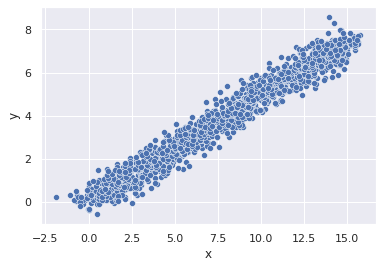

In [ ]:
#Data Visualization¶

sns.scatterplot(x="x", y="y", data=data)

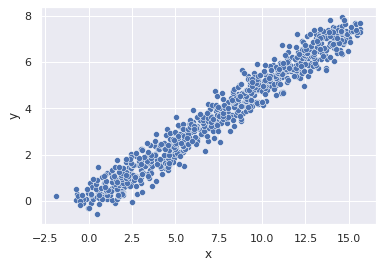

In [ ]:
sns.scatterplot(x="x", y="y", data=data_miss)

In [ ]:
#Missing values?
#Using pandas directly (fast but somehow limited)
#using imputation libraries (like missingno or autoimpute)
#Note here that autoimpute uses missingno

data_miss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1096 non-null   float64
 1   x       1155 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB


In [ ]:
print("Amount of data missing before imputation takes place")
pd.DataFrame(data_miss.isnull().sum(), columns=["records missing"]).T

Amount of data missing before imputation takes place


,y,x
records missing,404,345


In [ ]:
from autoimpute.visuals import plot_md_locations, plot_md_percent

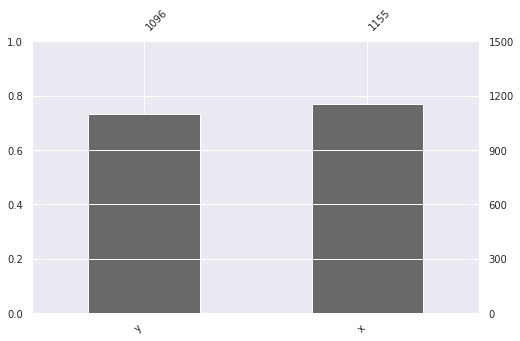

In [ ]:
# plotplot_md_percent(data_miss)
msno.bar(data_miss, figsize=(8,5), fontsize=10)

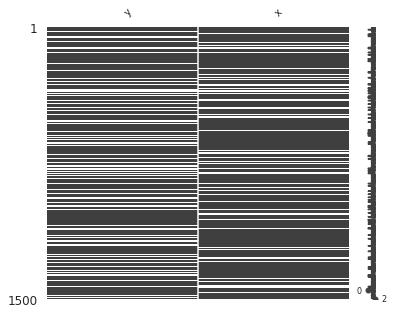

In [ ]:
# plot_md_location(data_miss)
msno.matrix(data_miss, figsize=(6,5), fontsize=10)

In [ ]:
# Correlation between missing values?
# https://github.com/ResidentMario/missingno#heatmap

#from autoimpute.visuals import plot_nullility_corr, plot_nullility_dendogram

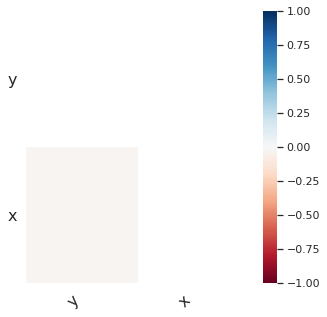

In [ ]:
#plot_nullility_corr(data_miss, figsize=(5,5))
msno.heatmap(data_miss, figsize=(5,5))

In [ ]:
#lmpact of missing values on the analysis

from sklearn.linear_model import LinearRegression

# prep for regression
X = data_miss.x.values.reshape(-1, 1) # reshape because one feature only
y = data_miss.y
lm = LinearRegression()

# try to fit the model
print_header("Fitting linear model to estimate relationship between X and y")
try:
    lm.fit(X, y)
except ValueError as ve:
    print(f"{ve.__class__.__name__}: {ve}")

In [ ]:
data_miss.shape

In [ ]:
# drop all rows that contains at least one missing value
data_miss.dropna(axis='index', how='any').shape

In [ ]:
# drop rows that only contains missing values
data_miss.dropna(axis='index', how='all').shape

In [ ]:
# keep rows that have at least 2 non missing values
data_miss.dropna(axis='index', thresh=2).shape

In [ ]:
# keep columns that contains at least 600 non-missing value
data_miss.dropna(axis='columns', thresh=1100).shape

In [ ]:
#Imputing values (Single Imputation)¶
#Single imputation vs multiple imputations

from autoimpute.imputations import SingleImputer, MultipleImputer

In [ ]:
# create the mean imputer
mean_imputer = SingleImputer(strategy='mean')

In [ ]:
# fit the imputer with train dataset
mean_imputer.fit(data_miss)

In [ ]:
# impute the data
data_imputed_once = mean_imputer.transform(data_miss)

In [ ]:
#Some informations about the imputed data

# amount of missing data after imputation
print_header("Amount of data missing after imputation takes place")
pd.DataFrame(data_imputed_once.isnull().sum(), columns=["records missing"]).T

In [ ]:
print_header("Showing the first 5 imputations for column x")
data_imputed_once.loc[mean_imputer.imputed_['x'], 'x'].head()

In [ ]:
data_miss['x'].mean()

In [ ]:
#Visualizing the imputed data
#https://autoimpute.readthedocs.io/en/latest/user_guide/visuals.html

from autoimpute.visuals import plot_imp_scatter
plot_imp_scatter(data_miss, 'x', 'y', strategy='mean')

In [ ]:
plot_imp_scatter(data_miss, 'x', 'y', strategy='least squares)

In [ ]:
plot_imp_scatter(data_miss, 'x', 'y', strategy='stochastic')

In [ ]:
#Comparing linear regressions, dropped missing values vs. imputed data vs original data¶

data_dropna                = data_miss.dropna()
data_imputed_mean          = SingleImputer(strategy='mean').fit_transform(data_miss)
data_imputed_least_squares = SingleImputer(strategy='least squares').fit_transform(data_miss)
data_imputed_stochastic    = SingleImputer(strategy='stochastic').fit_transform(data_miss)

In [ ]:
def prepare_data(df):
    return {'X':df.x.values.reshape(-1, 1), 'y':df.y.values.reshape(-1, 1)}

In [ ]:
from sklearn.linear_model import LinearRegression

# linear regressions with different data sets (TODO: train and test here) 
linreg_original              = LinearRegression().fit(**prepare_data(data))
linreg_dropna                = LinearRegression().fit(**prepare_data(data_dropna))
linreg_Imputed_mean          = LinearRegression().fit(**prepare_data(data_imputed_mean))
linreg_imputed_least_squares = LinearRegression().fit(**prepare_data(data_imputed_least_squares))
linreg_imputed_stochastic    = LinearRegression().fit(**prepare_data(data_imputed_stochastic))

In [ ]:
scores = pd.DataFrame.from_records({
    'original':linreg_original.score(**prepare_data(data)),
    'dropna':linreg_dropna.score(**prepare_data(data_dropna)),
    'Imputed_mean':linreg_Imputed_mean.score(**prepare_data(data_imputed_mean)),
    'imputed_least_squares':linreg_imputed_least_squares.score(**prepare_data(data_imputed_least_squares)),
    'imputed_stochastic':linreg_imputed_stochastic.score(**prepare_data(data_imputed_stochastic)),
}, index=['R2 score'])

In [ ]:
scores.T